### Notebook for the integration and creating cell-type hierarchy from the Healthy Human Heart to mouse heart using `treeArches`

- **Developed by:** Carlos Talavera-López Ph.D
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- v230926

### Import required modules

In [29]:
import os
import scvi
import torch
import warnings
import numpy as np
import scanpy as sc
import plotnine as p
import seaborn as sns
import scarches as sca
import matplotlib.pyplot as plt
from scarches.dataset.trvae.data_handling import remove_sparsity

### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.9.2
scanpy      1.9.5
-----
PIL                 10.0.1
absl                NA
aiohttp             3.8.5
aiosignal           1.3.1
annotated_types     0.5.0
anyio               NA
asttokens           NA
async_timeout       4.0.3
attr                23.1.0
backcall            0.2.0
backoff             2.2.1
bs4                 4.12.2
certifi             2023.07.22
charset_normalizer  3.2.0
chex                0.1.7
click               8.1.7
comm                0.1.4
contextlib2         NA
croniter            NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.8.0
decorator           5.1.1
deepdiff            6.5.0
docrep              0.3.2
etils               1.5.0
exceptiongroup      1.1.3
executing           1.2.0
fastapi             0.103.1
flax                0.7.4
frozenlist          1.4.0
fsspec              2023.9.2
h5py                3.9.0
idna                3.4
igraph              0.10.8
importlib_resources N

In [3]:
torch.set_float32_matmul_precision('high')

In [6]:
warnings.simplefilter(action = 'ignore')

scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

INFO: Global seed set to 1712
INFO:lightning.fabric.utilities.seed:Global seed set to 1712


In [7]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

### Read in Healthy data

In [8]:
reference = sc.read_h5ad('../data/hca_heart_global_ctl230918_states_formatted.h5ad')
reference

AnnData object with n_obs × n_vars = 452506 × 22260
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels'
    var: 'gene_ids-Harvard-Nuclei-full', 'feature_types-Harvard-Nuclei-full', 'gene_ids-Sanger-Nuclei-full', 'feature_types-Sanger-Nuclei-full', 'gene_ids-Sanger-Cells-full', 'feature_types-Sanger-Cells-full', 'gene_ids-Sanger-CD45-full', 'feature_types-Sanger-CD45-full', 'n_cells-myeloid', 'n_counts-myeloid'

- Remove annotations with less than 10 cells

In [9]:
reference.obs['seed_labels'].value_counts()

seed_labels
vCM1             71162
PC1_vent         50095
EC1_cap          27417
FB1              26632
vCM2             25658
                 ...  
CD4+T_Th1           74
gdT                 24
NC6                 24
unclassfied.2       20
CD4+T_Th17           8
Name: count, Length: 79, dtype: int64

In [10]:
reference.obs['seed_labels'].cat.categories

Index(['Adip1', 'Adip2', 'Adip3', 'Adip4', 'B', 'B_plasma', 'CD14+Mo',
       'CD4+T_Tfh', 'CD4+T_Th1', 'CD4+T_Th17', 'CD4+T_Th2', 'CD4+T_act',
       'CD4+T_naive', 'CD4+T_reg', 'CD69+Mo', 'CD8+T_cytox', 'CD8+T_em',
       'CD8+T_te', 'CD8+T_trans', 'Cycling_T/NK', 'DC2', 'DOCK4+aMØ',
       'DOCK4+vMØ', 'EC10_CMC-like', 'EC1_cap', 'EC2_cap', 'EC3_cap',
       'EC4_immune', 'EC5_art', 'EC6_ven', 'EC7_atria', 'EC8_ln',
       'EC9_FB-like', 'FB1', 'FB2', 'FB3', 'FB4', 'FB5', 'FB6', 'ILC',
       'LYVE1+MØ1', 'LYVE1+MØ2', 'M2MØ', 'MAIT-like', 'Mast', 'Meso', 'MoMø',
       'NC1', 'NC2', 'NC3', 'NC4', 'NC5', 'NC6', 'NK_CD16hi', 'NK_CD56hi',
       'NØ', 'PC1_vent', 'PC2_atria', 'PC3_str', 'PC4_CMC-like', 'SMC1_basic',
       'SMC2_art', 'TREM2+MØ', 'aCM1', 'aCM2', 'aCM3', 'aCM4', 'aCM5', 'gdT',
       'nøMo', 'pDC', 'proIMØ', 'unclassfied.1', 'unclassfied.2', 'vCM1',
       'vCM2', 'vCM3', 'vCM4', 'vCM5'],
      dtype='object')

### Subset populations of interest

In [11]:
reference = reference[~reference.obs['seed_labels'].isin(['nan', 'NC1', 'NC2', 'NC3', 'NC4', 'NC5', 'NC6', 'EC10_CMC-like', 'PC3_str', 'PC4_CMC-like'])]
reference.obs['seed_labels'].value_counts()

seed_labels
vCM1             71162
PC1_vent         50095
EC1_cap          27417
FB1              26632
vCM2             25658
                 ...  
pDC                 79
CD4+T_Th1           74
gdT                 24
unclassfied.2       20
CD4+T_Th17           8
Name: count, Length: 70, dtype: int64

In [12]:
sc.pp.filter_cells(reference, min_genes = 200)
sc.pp.filter_cells(reference, min_counts = 100)

In [13]:
reference.obs['cell_source'].value_counts()

cell_source
Harvard-Nuclei    158632
Sanger-Nuclei     157632
Sanger-CD45        70042
Sanger-Cells       43193
Name: count, dtype: int64

### Read in other query

In [14]:
query = sc.read_h5ad('../data/heart_mm_nuclei-23-0092_CB_QCed_ctl230918.raw.h5ad')
query.obs['cell_source'] = 'HIRI-Nuclei'
query.obs['seed_labels'] = 'Unknown'
query.obs['donor'] = query.obs['sample'].copy()
query

AnnData object with n_obs × n_vars = 143257 × 32285
    obs: 'sample', 'genotype', 'batch', 'n_genes', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'cell_source', 'seed_labels', 'donor'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors'
    layers: 'counts', 'sqrt_norm'

In [15]:
sc.pp.filter_cells(query, min_genes = 200)
sc.pp.filter_cells(query, min_counts = 100)

### Change gene symbols for label transfer

In [16]:
query.var_names = [gene_name.upper() for gene_name in query.var_names]
query.var_names

Index(['XKR4', 'GM1992', 'GM19938', 'GM37381', 'RP1', 'SOX17', 'GM37587',
       'GM37323', 'MRPL15', 'LYPLA1',
       ...
       'GM16367', 'AC163611.1', 'AC163611.2', 'AC140365.1', 'AC124606.2',
       'AC124606.1', 'AC133095.2', 'AC133095.1', 'AC234645.1', 'AC149090.1'],
      dtype='object', length=32285)

In [17]:
adata = reference.concatenate(query, batch_key = 'batch', batch_categories = ['reference', 'query'], join = 'inner')
adata

AnnData object with n_obs × n_vars = 572756 × 14249
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids-query', 'feature_types-query', 'genome-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'gene_ids-Harvard-Nuclei-full-reference', 'feature_types-Harvard-Nuclei-full-reference', 'gene_ids-Sanger-Nuclei-full-reference', 'feature_types-Sanger-Nuclei-full-reference', 'gene_ids-Sanger-Cells-full-reference', 'feature_types-Sanger-Cells-full-reference', 'gene_ids-Sanger-CD45-full-reference', 'feature_types-Sanger-CD45-full-reference', 'n_cells-myeloid-refe

In [18]:
adata.obs['seed_labels'] = adata.obs['seed_labels'].astype('category')
adata.obs['seed_labels'].value_counts()

seed_labels
Unknown          143257
vCM1              71162
PC1_vent          50095
EC1_cap           27417
FB1               26632
                  ...  
pDC                  79
CD4+T_Th1            74
gdT                  24
unclassfied.2        20
CD4+T_Th17            8
Name: count, Length: 71, dtype: int64

In [19]:
adata.obs['batch'].value_counts()

batch
reference    429499
query        143257
Name: count, dtype: int64

### Process data according to `treeArches` workflow

In [20]:
target_conditions = ["donor"]
source_adata = adata[adata.obs.batch.isin(['reference'])].copy()
target_adata = adata[~adata.obs.batch.isin(['reference'])].copy()
print(source_adata)
print(target_adata)

AnnData object with n_obs × n_vars = 429499 × 14249
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids-query', 'feature_types-query', 'genome-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'gene_ids-Harvard-Nuclei-full-reference', 'feature_types-Harvard-Nuclei-full-reference', 'gene_ids-Sanger-Nuclei-full-reference', 'feature_types-Sanger-Nuclei-full-reference', 'gene_ids-Sanger-Cells-full-reference', 'feature_types-Sanger-Cells-full-reference', 'gene_ids-Sanger-CD45-full-reference', 'feature_types-Sanger-CD45-full-reference', 'n_cells-myeloid-refe

### Select HVGs for `source_adata`

In [22]:
source_adata_raw = source_adata.copy()
source_adata.layers['counts'] = source_adata.X.copy()

sc.pp.highly_variable_genes(
    source_adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "donor",
    subset = True
    )

source_adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 429499 × 7000
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids-query', 'feature_types-query', 'genome-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'gene_ids-Harvard-Nuclei-full-reference', 'feature_types-Harvard-Nuclei-full-reference', 'gene_ids-Sanger-Nuclei-full-reference', 'feature_types-Sanger-Nuclei-full-reference', 'gene_ids-Sanger-Cells-full-reference', 'feature_types-Sanger-Cells-full-reference', 'gene_ids-Sanger-CD45-full-reference', 'feature_types-Sanger-CD45-full-reference', 'n_cells-myeloid-refer

### Transfer of annotation with scANVI

In [23]:
scvi.model.SCVI.setup_anndata(source_adata, 
                              batch_key = 'donor', 
                              labels_key = 'seed_labels',
                              layer = 'counts',
                              categorical_covariate_keys = ['donor', 'cell_source'])

I0000 00:00:1695729309.883720    4251 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [24]:
scvi_model = scvi.model.SCVI(source_adata, n_latent = 50, n_layers = 3, dispersion = 'gene-batch', gene_likelihood = 'nb')

In [25]:
scvi_model.train(60, check_val_every_n_epoch = 1, enable_progress_bar = True, use_gpu = 1)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 60/60: 100%|██████████| 60/60 [18:51<00:00, 19.05s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=1.82e+3]

INFO: `Trainer.fit` stopped: `max_epochs=60` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=60` reached.


Epoch 60/60: 100%|██████████| 60/60 [18:51<00:00, 18.86s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=1.82e+3]


### Evaluate model performance a la _Sevensson_

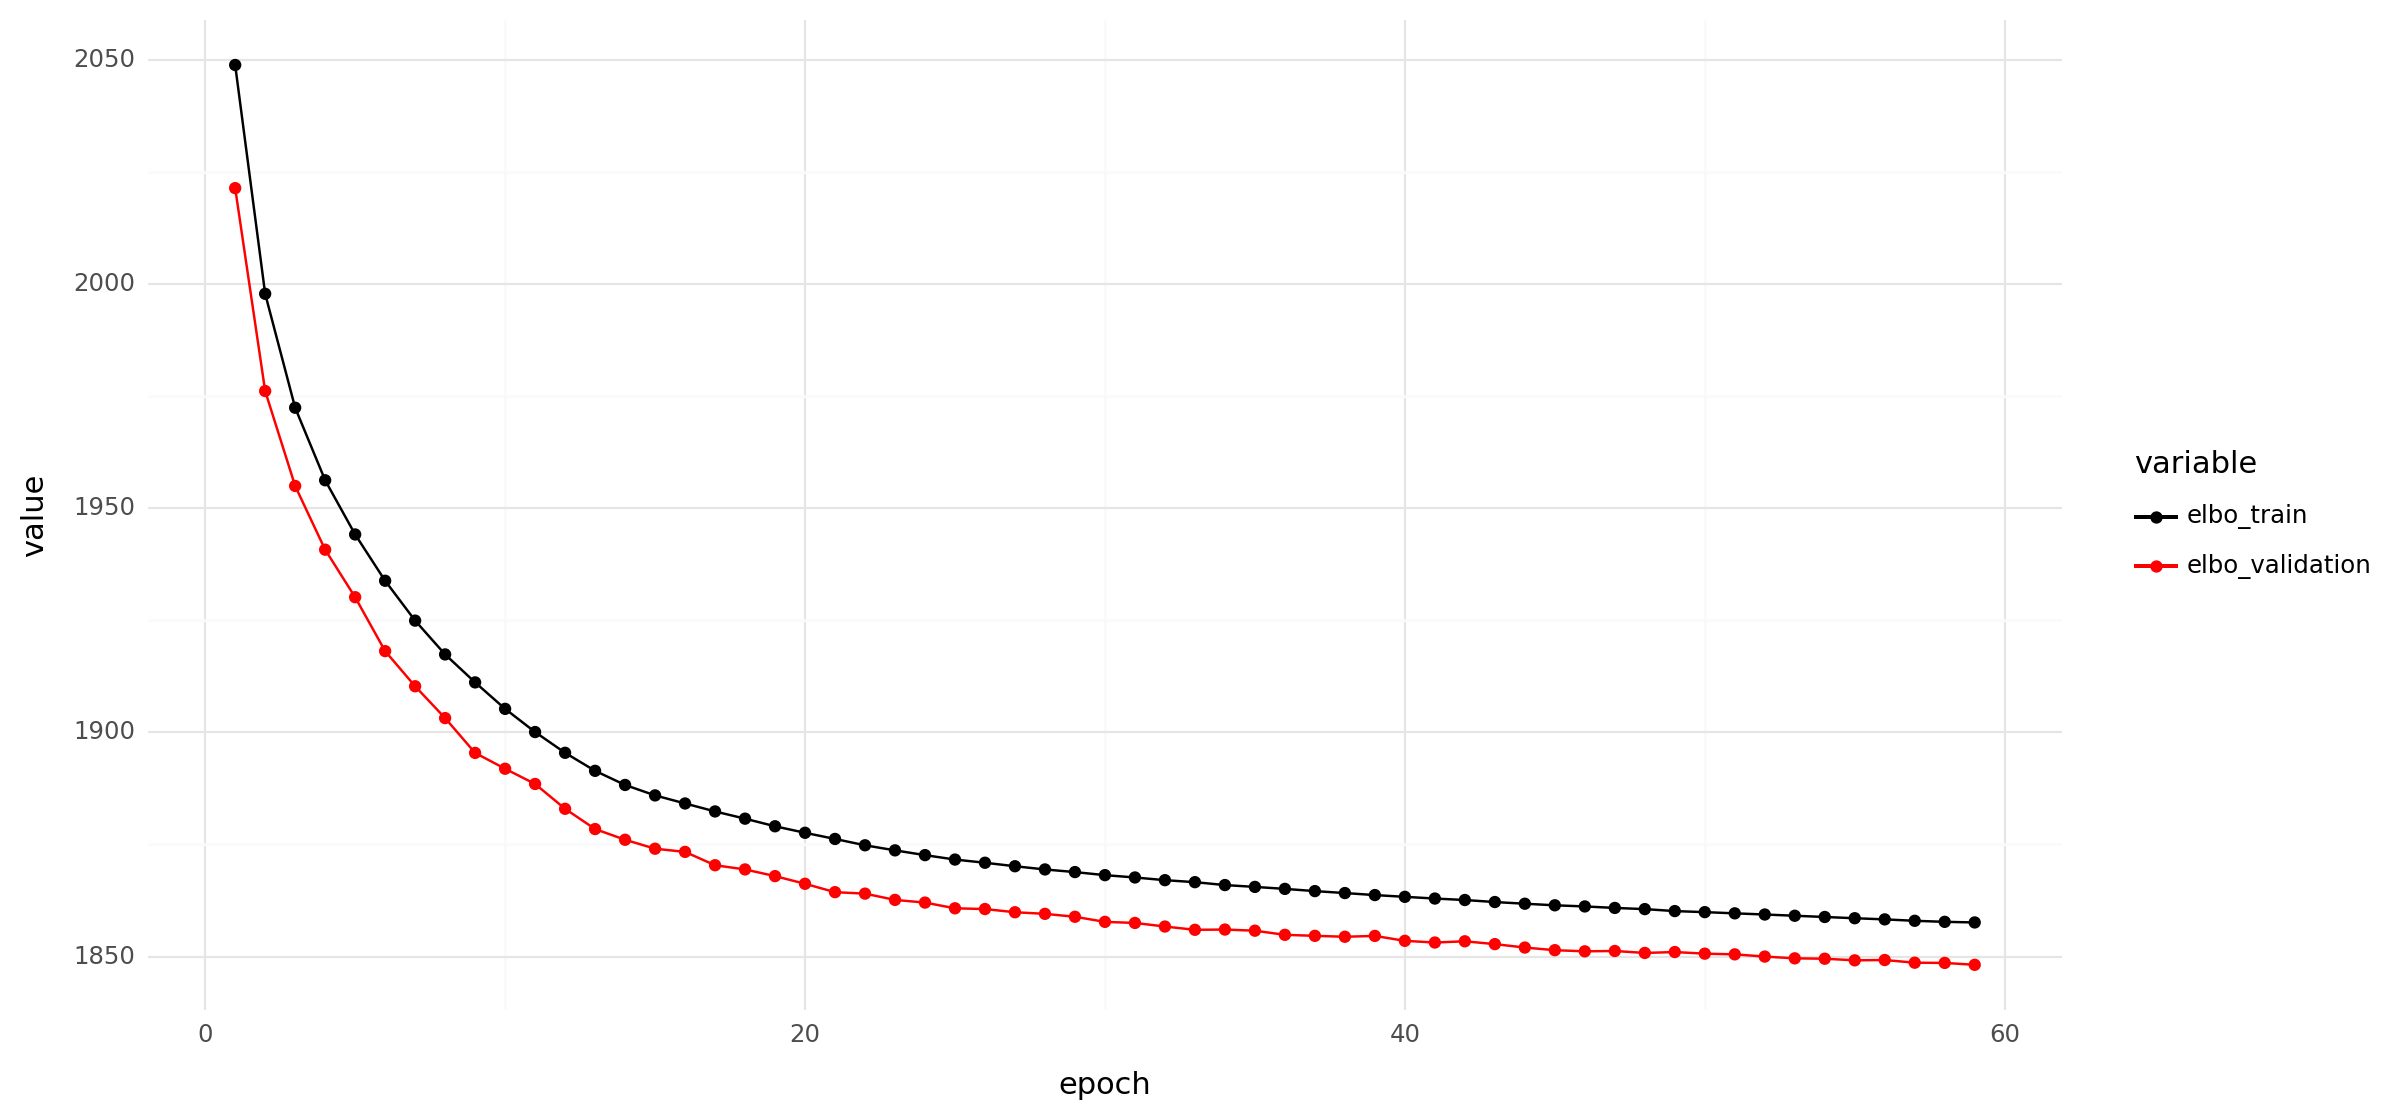

In [30]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

- Extract latent representation

In [31]:
source_adata.obsm["X_scVI"] = scvi_model.get_latent_representation(source_adata)

- Visualise corrected dataset

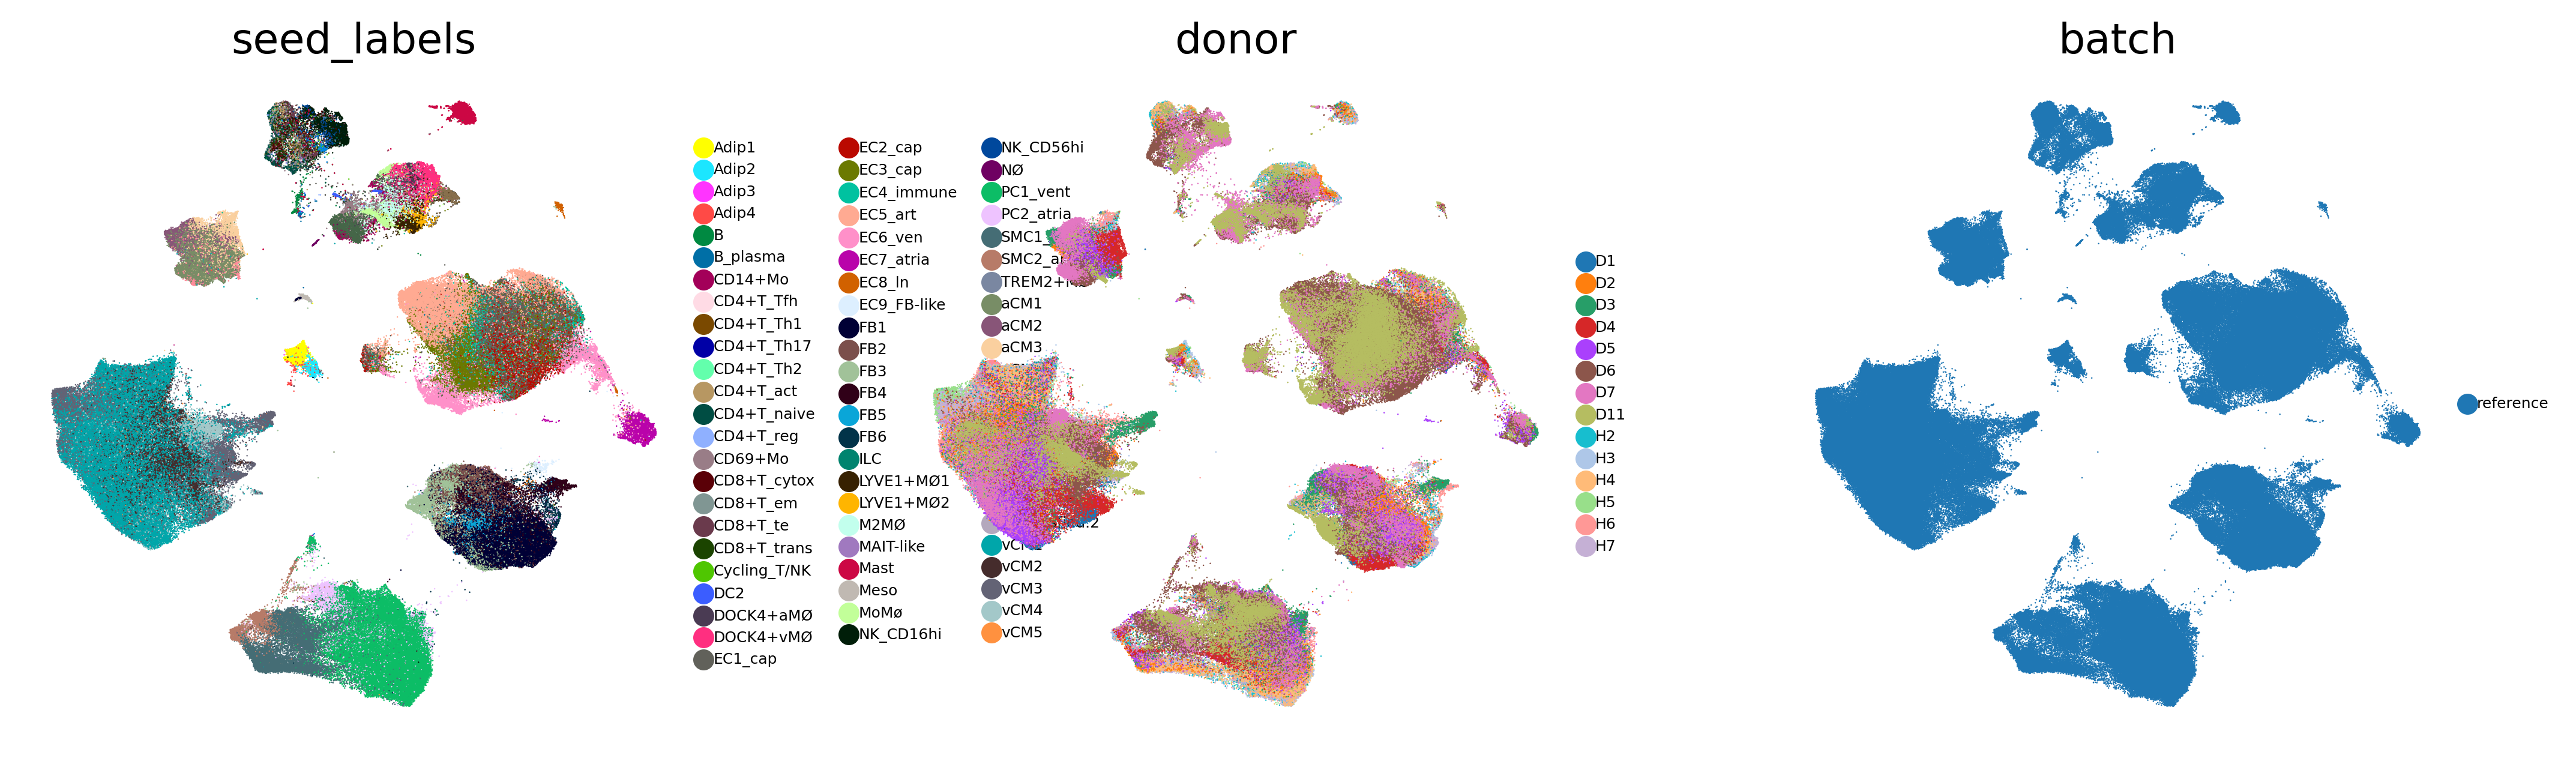

In [34]:
sc.pp.neighbors(source_adata, use_rep = "X_scVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(source_adata, min_dist = 0.3, spread = 4, random_state = 1712)
sc.pl.umap(source_adata, frameon = False, color = ['seed_labels', 'donor', 'batch'], size = 1, legend_fontsize = 5, ncols = 3)

### Construct hierarchy for the reference using scHPL

In [33]:
source_adata.obs['celltype_batch'] = np.char.add(np.char.add(np.array(source_adata.obs['seed_labels'], dtype = str), '-'),
                                             np.array(source_adata.obs['donor'], dtype = str))

Starting tree:


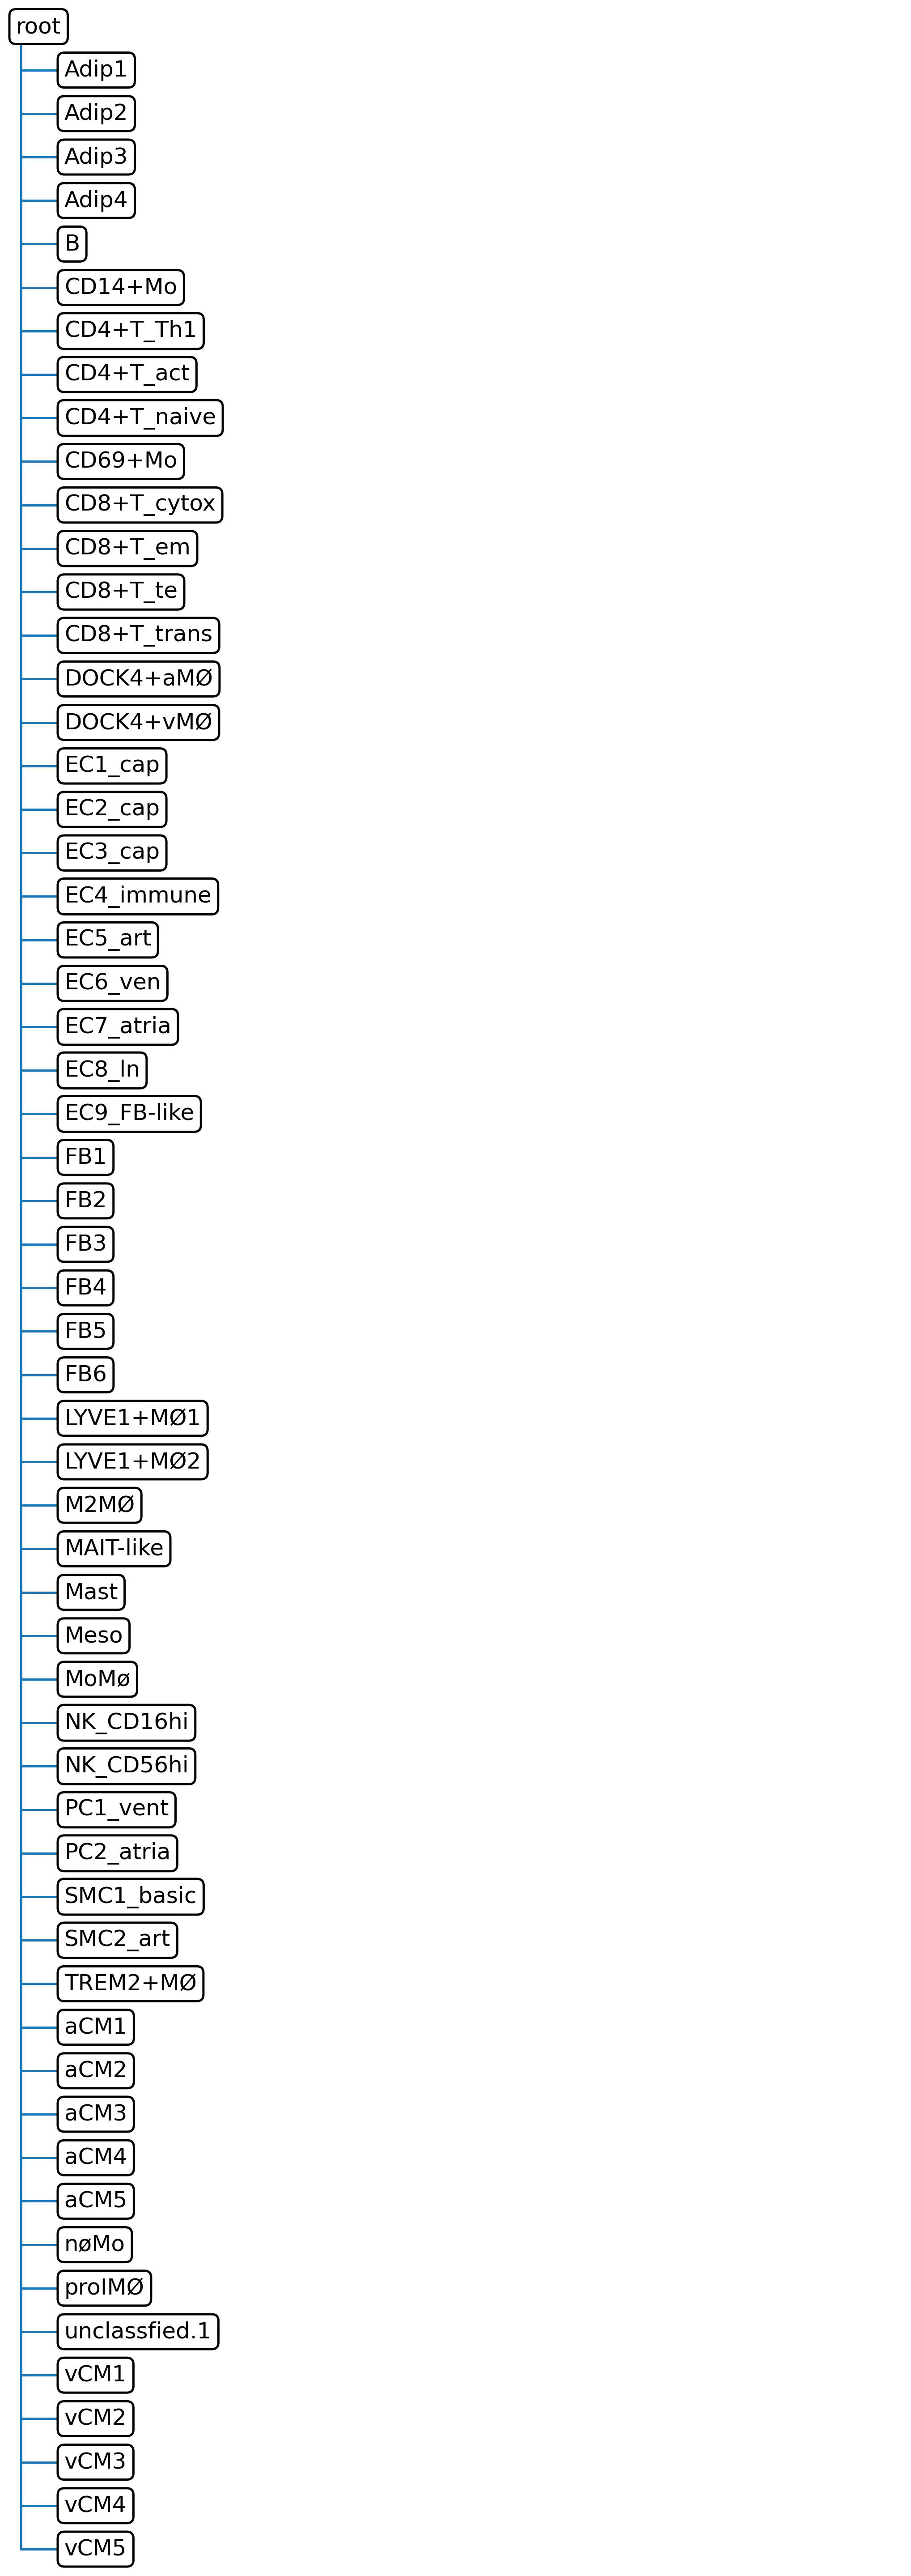


Adding dataset D2 to the tree


TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

In [35]:
tree_ref, mp_ref = sca.classifiers.scHPL.learn_tree(data = source_adata,
                batch_key = 'donor',
                batch_order = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D11', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7'],
                cell_type_key = 'seed_labels',
                classifier = 'knn', dynamic_neighbors = True,
                dimred = False, print_conf = False)

### Add new gene symbols

In [ ]:
query_export = anndata.AnnData(X = query.X, var = query.var, obs = adata_export.obs)
query_export

### Revert gene symbols

In [ ]:
query_export.var_names = [gene_name.capitalize() for gene_name in query_export.var_names]
query_export.var_names

In [ ]:
query_export.obs['C_scANVI'].value_counts()

In [ ]:
query_export